In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [17]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
wetter = pd.read_csv("Data/wetter.csv")
kiwo = pd.read_csv("Data/kiwo.csv")
submission = pd.read_csv("Data/sample_submission.csv")

# Convert 'date' column to datetime format
train['Datum'] = pd.to_datetime(train['Datum'])
test['Datum'] = pd.to_datetime(test['Datum'])
wetter['Datum'] = pd.to_datetime(wetter['Datum'])
kiwo['Datum'] = pd.to_datetime(kiwo['Datum'])

# Add Weekday and Month as Feature
train['Wochentag'] = train['Datum'].dt.day_name()
test['Wochentag'] = test['Datum'].dt.day_name()
train["Monat"] = train["Datum"].dt.month
test["Monat"] = test["Datum"].dt.month

# merge wetter and kiwo data with train and test datasets
train = pd.merge(train, wetter, on='Datum', how='left')
train = pd.merge(train, kiwo, on='Datum', how='left')
test = pd.merge(test, wetter, on='Datum', how='left')
test = pd.merge(test, kiwo, on='Datum', how='left')


In [18]:
print(train.columns)

Index(['id', 'Datum', 'Warengruppe', 'Umsatz', 'Wochentag', 'Monat',
       'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode',
       'KielerWoche'],
      dtype='object')


In [19]:
print(test.columns)

Index(['id', 'Datum', 'Warengruppe', 'Wochentag', 'Monat', 'Bewoelkung',
       'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche'],
      dtype='object')


In [21]:
# define goal variable
y = train["Umsatz"]

#prepare features
X = train.drop(columns=['Umsatz', 'Datum'])  
# every column except 'Umsatz' and 'Datum' is a feature
# since 'Umsatz' is the target and 'Datum' is already considered via 'Wochentag' and 'Month'

# Prepare test features
X_test = test.drop(columns=['Datum'])

In [22]:
# identify categorical columns for encoding
cat_cols = X.select_dtypes(include="object").columns.tolist()

# merge training and test data for consistent encoding
all_data = pd.concat([X, X_test], axis=0, ignore_index=True)
# One-hot encoding for categorical variables
all_data_encoded = pd.get_dummies(all_data, columns=cat_cols)

# split back into training and test sets
X_encoded = all_data_encoded.iloc[:len(X)]      # first len(X) rows = Trainingdaten
X_test_encoded = all_data_encoded.iloc[len(X):] # rest = Testdaten

In [23]:
# use median to fill NaN values
X_encoded = X_encoded.fillna(X_encoded.median())
X_test_encoded = X_test_encoded.fillna(X_encoded.median())

In [24]:
# check for nan
print(train.isna().sum())

id                        0
Datum                     0
Warengruppe               0
Umsatz                    0
Wochentag                 0
Monat                     0
Bewoelkung               70
Temperatur               16
Windgeschwindigkeit      16
Wettercode             2325
KielerWoche            9111
dtype: int64


In [28]:
# Lineare Regression Modell (einfachste Variante)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model = LinearRegression()

# Das Modell lernt aus den Daten
model.fit(X_encoded, y)

# Vorhersagen treffen
preds = model.predict(X_test_encoded)

# Modell-Qualität anzeigen (R² Score)
train_preds = model.predict(X_encoded)
r2 = r2_score(y, train_preds)
print(f"R² Score: {r2:.4f}")

# Zeige die wichtigsten Faktoren
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nWichtigste Faktoren (Koeffizienten):")
print(feature_importance.head(10))

R² Score: 0.0877

Wichtigste Faktoren (Koeffizienten):
                feature  coefficient
11     Wochentag_Sunday    39.574629
10   Wochentag_Saturday    35.260098
14  Wochentag_Wednesday   -19.234311
13    Wochentag_Tuesday   -18.761094
12   Wochentag_Thursday   -13.418546
9      Wochentag_Monday   -12.881821
8      Wochentag_Friday   -10.538955
1           Warengruppe    -4.800811
4            Temperatur     4.539913
2                 Monat    -2.206533


In [30]:
# Modell-Qualität anzeigen
r2 = r2_score(y, train_preds)
mae = mean_absolute_error(y, train_preds)
rmse = mean_squared_error(y, train_preds) ** 0.5

print(f"R² Score: {r2:.4f}")
print(f"Mittlerer Absoluter Fehler: {mae:.2f}€")
print(f"Wurzel des mittleren quadratischen Fehlers: {rmse:.2f}€")

R² Score: 0.0877
Mittlerer Absoluter Fehler: 108.94€
Wurzel des mittleren quadratischen Fehlers: 138.06€


In [27]:
# Vergleich als Tabelle
comparison = pd.DataFrame({
    'Actual': y.values,
    'Predicted': train_preds,
    'Difference': y.values - train_preds
})
print("\nVergleich (erste 10 Zeilen):")
print(comparison.head(10))


Vergleich (erste 10 Zeilen):
       Actual   Predicted  Difference
0  148.828353  251.811329 -102.982976
1  159.793757  241.581114  -81.787357
2  111.885594  257.285416 -145.399822
3  168.864941  253.432485  -84.567544
4  171.280754  262.759083  -91.478329
5  174.552360  302.102739 -127.550379
6   92.637755  317.688059 -225.050304
7  135.500244  271.742896 -136.242652
8  136.048383  267.657439 -131.609056
9  135.132314  252.788638 -117.656323


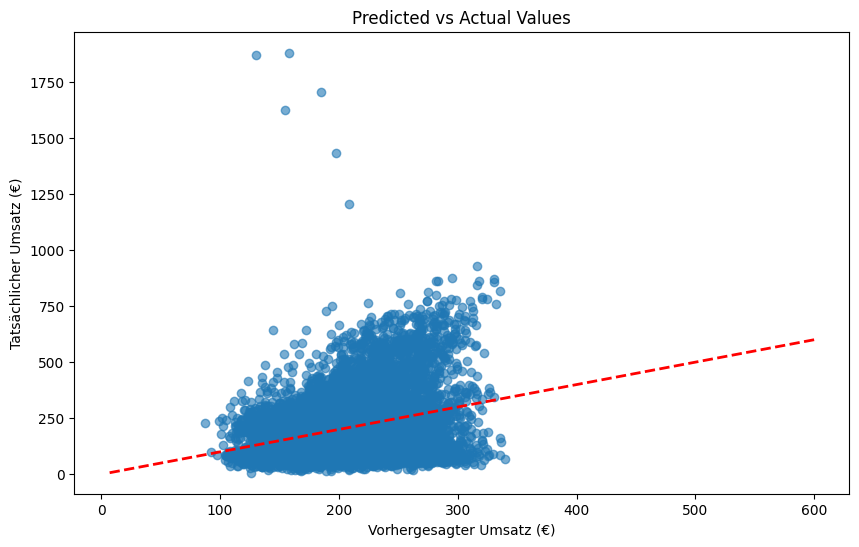

In [33]:
# Scatter Plot: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(train_preds, y, alpha=0.6)
plt.plot([y.min(), 600], [y.min(), 600], 'r--', lw=2)
plt.ylabel('Tatsächlicher Umsatz (€)')
plt.xlabel('Vorhergesagter Umsatz (€)')
plt.title('Predicted vs Actual Values')
plt.show()